# Exploring Multi-Network Seismic Data Access and Automated Event Location  

This notebook demonstrates a practical workflow for **accessing seismic waveform data from multiple networks**, performing **automated phase picking**, and generating **preliminary earthquake locations**.

The primary focus is on working with data from:
- **VW** – University of Melbourne seismic network  
- **OZ** – Seismology Research Centre network  

with additional stations drawn from other publicly available networks where useful.  
A key aim is to show how heterogeneous data from multiple providers can be accessed, merged, and analysed in a reproducible way.

---

## Example Event

As a concrete test case, the notebook analyses a **small local earthquake (≈ ML 3.0) near Moe, Victoria**, recorded on **3 February 2026**.  
A reference solution for this event is available from **Geoscience Australia**:

🔗 https://earthquakes.ga.gov.au/event/ga2026cjayif

This event is used primarily as a **worked example** to demonstrate the workflow, rather than as a definitive relocation exercise.

---

## Scope of the Notebook

The workflow demonstrated here includes:
- Querying and downloading waveform data and station metadata from **multiple FDSN providers**
- Combining inventories and waveforms across networks
- Automated **P and S phase picking** using **SeisBench**
- **Event association and preliminary location** using **PyOcto**
- Diagnostic plotting of waveforms and picks to assess data quality and algorithm behaviour

The locations produced in this notebook are **intentionally preliminary** and are not intended to replace authoritative catalogue solutions or detailed relocation studies.

---

## Core Python Packages

This notebook relies on the following core packages:

- **NumPy** – numerical arrays and basic analysis  
- **Matplotlib** – plotting and visualisation  
- **ObsPy** – waveform handling, station metadata, and time utilities  
- **SeisBench** – machine-learning phase pickers  
- **PyOcto** – octree-based event association and coarse location  
- **PyTorch** – backend for SeisBench models  

In addition, a small set of **local utility functions** is used for data collection, formatting, and plotting.

---

**Author: Dan Sandiford**


In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime, read, read_inventory
from obspy.core.inventory import Inventory

# make project utils importable
project_root = Path.cwd().parent.resolve()
sys.path.insert(0, str(project_root))

# local utilities
from utils import (
    Provider,
    collect_stations_and_waveforms,
    convert_to_catalog,
    SRC_velocity_format,
    plot_station_picks_panel,
)

In [2]:
UOM_SERVER = "https://subsurface.science.unimelb.edu.au"
AUSPASS_SERVER = "https://auspass.edu.au"
RS_SERVER = "https://data.raspberryshake.org"
IRIS_SERVER = "IRIS"


providers = [
    Provider("UoM", UOM_SERVER),                 # <-- added (highest priority)
    Provider("AUSPASS", AUSPASS_SERVER),
    Provider("RaspberryShake", RS_SERVER),
    Provider("ANSN", IRIS_SERVER),
]


network_codes = ["VW", "OZ", "AM", "AU", "S1"]


# Dummy start time – replace this with whatever you want
starttime = UTCDateTime("2026-02-03T06:00:00")
search_lat = -38.3
search_lon = 146.6
# Duration in seconds (10 minutes)
duration = 10 * 60
endtime = starttime + duration

## Download data (or read in from file) 

In [3]:
USE_DISK = True

data_dir = Path.cwd()    # or Path.home() / "ex01"
data_dir.mkdir(parents=True, exist_ok=True)
mseed_path = data_dir / "ex01.mseed"
inv_path   = data_dir / "ex01.xml"



if USE_DISK and mseed_path.exists() and inv_path.exists():
    st = read(str(mseed_path))
    inv_all = read_inventory(str(inv_path))
    selections = None

else:
    st, selections = collect_stations_and_waveforms(
        providers=providers,
        requested_networks=network_codes,   # ["VW","OZ","AM","AU","S1"]
        latitude=search_lat,
        longitude=search_lon,
        maxradius=1.0,
        starttime=starttime,
        endtime=endtime,
        channel="*",
        location="*",
        attach_response=False,
    )

    # combine inventory from provider selections
    inv_all = Inventory(networks=[], source="")
    for name, sel in selections.items():
        inv_all += sel.inventory
        print(f"{name}: networks={sel.networks}, stations={len(sel.stations)}")

    # save only if files don't exist
    if not mseed_path.exists():
        st.write(str(mseed_path), format="MSEED")
    if not inv_path.exists():
        inv_all.write(str(inv_path), format="STATIONXML")

# filter inv_all to only NET.STA that exist in st
have_net_sta = {(tr.stats.network, tr.stats.station) for tr in st}
inv_filt = Inventory(networks=[], source=inv_all.source)

for net in inv_all:
    kept_stations = [sta for sta in net if (net.code, sta.code) in have_net_sta]
    if not kept_stations:
        continue
    net2 = net.copy()
    net2.stations = kept_stations
    inv_filt.networks.append(net2)

inv_all = inv_filt

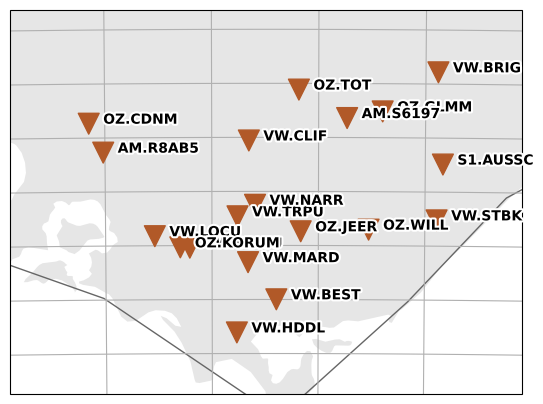

In [4]:
inv_all.plot(projection="local");

## Picks with Seisbench / Phasenet

In [6]:
import torch
import seisbench.models as sbm
from seisbench.util.annotations import Pick, PickList
import pyocto

In [7]:
#params
freqmin=2.0
freqmax=40.0
phasenet_model = "original"
n_picks = 6
n_p_and_s_picks = 3
P_threshold=0.25
S_threshold=0.25

In [8]:
picker = sbm.PhaseNet.from_pretrained(phasenet_model)

In [9]:
st.resample(100.0)
st.detrend("linear")
st.taper(0.05)
st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

# Either pick on the Pick
picks = picker.classify(st, batch_size=256, P_threshold=P_threshold, S_threshold=S_threshold).picks

picks, S_threshold

(PickList with 77 entries:
 
 AM.S6197.00	2026-02-03T06:02:50.173000Z	P
 OZ.CDNM.60	2026-02-03T06:02:59.900000Z	P
 OZ.CDNM.60	2026-02-03T06:03:10.080000Z	S
 ...
 VW.STBK.00	2026-02-03T06:07:02.310000Z	P
 VW.TRPU.00	2026-02-03T06:02:42.110000Z	P
 VW.TRPU.00	2026-02-03T06:02:51.950000Z	P,
 0.25)

## Event Association

In [10]:
#We'll start with a simple constant velocity model (the values represent the uppermost (<20 km)  layer of the IASPEI91 model)


velocity_model = pyocto.VelocityModel0D(
    p_velocity=5.8,
    s_velocity=3.46,
    tolerance=1.0,
    association_cutoff_distance=250,
)


In [11]:
# --- 1) Compute centroid of stations (simple mean of lat/lon) ---
lats, lons = [], []

for net in inv_all:
    for sta in net:
        # station-level coordinates live here if present
        if sta.latitude is None or sta.longitude is None:
            continue
        lats.append(float(sta.latitude))
        lons.append(float(sta.longitude))

if not lats:
    raise ValueError("No station coordinates found in `inv` (station latitude/longitude missing).")

lat_c = float(np.mean(lats))
lon_c = float(np.mean(lons))

print(f"Centroid: lat={lat_c:.4f}, lon={lon_c:.4f} (deg)")

# --- 2) Build a 2° x 2° box centered on that centroid ---
half_size = 1.0  # degrees (2° square => +/- 1°)

lat_box = (lat_c - half_size, lat_c + half_size)
lon_box = (lon_c - half_size, lon_c + half_size)

# Optional: clip latitude to valid range
lat_box = (max(-90.0, lat_box[0]), min(90.0, lat_box[1]))

print("Area:")
print("  lat:", lat_box)
print("  lon:", lon_box)

# --- 3) Apply to OctoAssociator.from_area ---
# You must provide `velocity_model` (a pyocto.associator.VelocityModel instance)
# and choose `zlim` (km) and `time_before` (seconds) appropriate for your use.

zlim = (0.0, 40.0)         # km, example
time_before = 60.0         # s, example

Centroid: lat=-38.2114, lon=146.2983 (deg)
Area:
  lat: (-39.21140045168326, -37.21140045168326)
  lon: (145.29825196989114, 147.29825196989114)


In [12]:
associator = pyocto.OctoAssociator.from_area(
    lat=lat_box,
    lon=lon_box,
    zlim=(0, 50),
    time_before=20,
    velocity_model=velocity_model,
    n_picks=n_picks,
    n_p_and_s_picks=n_p_and_s_picks,
)

In [13]:
#note that this doesn't work quite properly, so some cleaning is requited
stations = associator.inventory_to_df(inv_all)
# Clean up station IDs coming from inventory_to_df:
# - IDs look like "NET.STA.LOC" where LOC may be blank => "NET.STA."
# - We want ONE row per physical station (NET+STA)
# - Prefer non-blank LOC (e.g. "00", "60") when available

stations = stations.copy()
stations["id"] = stations["id"].astype(str).str.strip()

parts = stations["id"].str.split(".", expand=True)
stations["net"] = parts[0]
stations["sta"] = parts[1]
stations["loc"] = parts[2].fillna("")   # blank loc becomes ""

# Rank: non-blank loc is better (rank 0) than blank loc (rank 1)
stations["_loc_blank"] = (stations["loc"] == "").astype(int)

stations_clean = (
    stations
    .sort_values(["net", "sta", "_loc_blank"])          # keep non-blank first
    .drop_duplicates(subset=["net", "sta"], keep="first")  # one per station
    .drop(columns=["_loc_blank"])
    .reset_index(drop=True)
)

In [14]:
stations_clean["id"]


0     AM.R8AB5.00
1     AM.S6197.00
2      OZ.CDNM.60
3        OZ.GLMM.
4        OZ.JEER.
5     OZ.KORUM.60
6       OZ.TOT.00
7      OZ.WILL.00
8       S1.AUSSC.
9      VW.BEST.00
10     VW.BRIG.00
11     VW.CLIF.00
12     VW.HDDL.00
13     VW.LOCU.00
14     VW.MARD.00
15     VW.NARR.00
16     VW.SGWU.00
17     VW.STBK.00
18     VW.TRPU.00
Name: id, dtype: object

In [15]:
#Main association step: events

events, assignments = associator.associate_seisbench(picks, stations)
print(f"seisbench/pyocto found {len(events)} earthquakes")


seisbench/pyocto found 1 earthquakes


In [16]:
#Let's transform it back to latitude and longitude 
associator.transform_events(events)

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,1.770099e+09,7.628316,19.305955,16.015625,35,-38.037439,146.385147,16.015625


In [17]:
#stations_clean

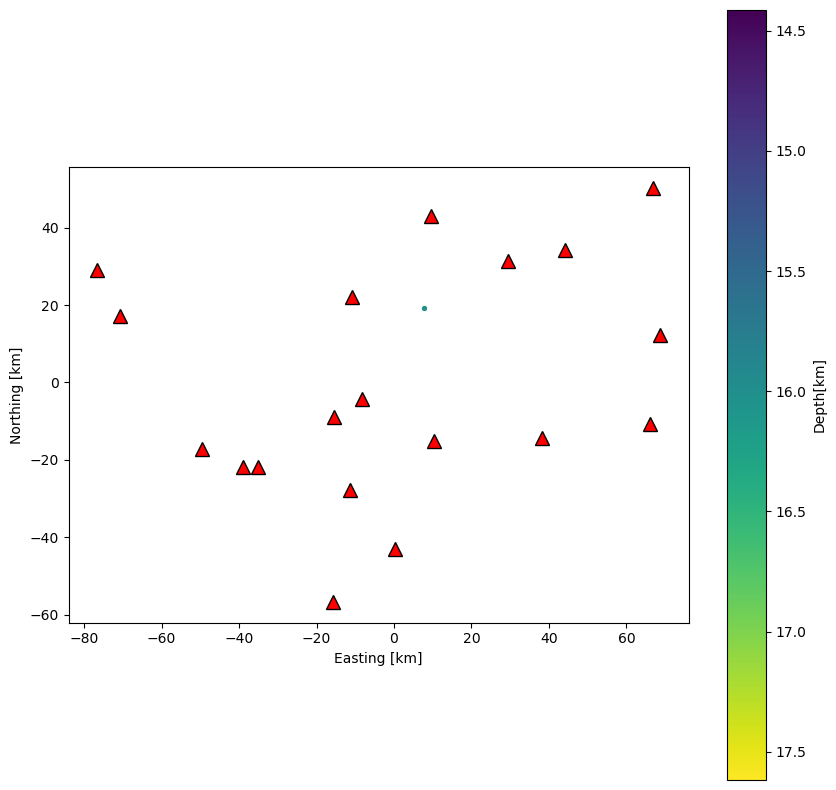

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(events["x"], events["y"], c=events["z"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(stations_clean["x"], stations_clean["y"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

## Save the assigments

In [ ]:
#in this example, there is only one event. If pyOcto find more than one event, the assighments are filtered like this:
assignments[assignments["event_idx"] == 0]

In [122]:

assignments["time_utc"] = assignments["time"].apply(UTCDateTime)
assignments.to_csv("ex01/ex01_assignments.csv", index=False)


In [123]:
from IPython.display import display
display(assignments)

,event_idx,pick_idx,residual,station,time,probability,phase,time_utc
0,0,0,0.038030,AM.S6197.00,1.770099e+09,0.445067,P,2026-02-03T06:02:50.173000Z
1,0,1,-0.005048,OZ.CDNM.60,1.770099e+09,0.922912,P,2026-02-03T06:02:59.900000Z
2,0,2,0.092817,OZ.CDNM.60,1.770099e+09,0.710447,S,2026-02-03T06:03:10.080000Z
3,0,3,-0.052979,OZ.GLMM.,1.770099e+09,0.965537,P,2026-02-03T06:02:52.271667Z
4,0,4,-0.368484,OZ.GLMM.,1.770099e+09,0.916455,S,2026-02-03T06:02:56.911667Z
5,0,6,-0.515800,OZ.JEER.,1.770099e+09,0.968088,P,2026-02-03T06:02:51.063000Z
6,0,7,-0.276888,OZ.JEER.,1.770099e+09,0.701671,S,2026-02-03T06:02:55.753000Z
7,0,9,0.006296,OZ.KORUM.60,1.770099e+09,0.957819,P,2026-02-03T06:02:56.090000Z
8,0,10,0.208539,OZ.KORUM.60,1.770099e+09,0.828549,S,2026-02-03T06:03:03.790000Z
9,0,15,0.099008,OZ.TOT.00,1.770099e+09,0.962562,P,2026-02-03T06:02:50.121000Z


## Plot some of the picks 

In [19]:
stations_to_plot = (
    assignments
    .query("phase == 'P'")
    .sort_values("time")
    .station
    .str.split(".", expand=True)[1]
    .unique()
    .tolist()
)



In [104]:
#help(plot_station_picks_panel)

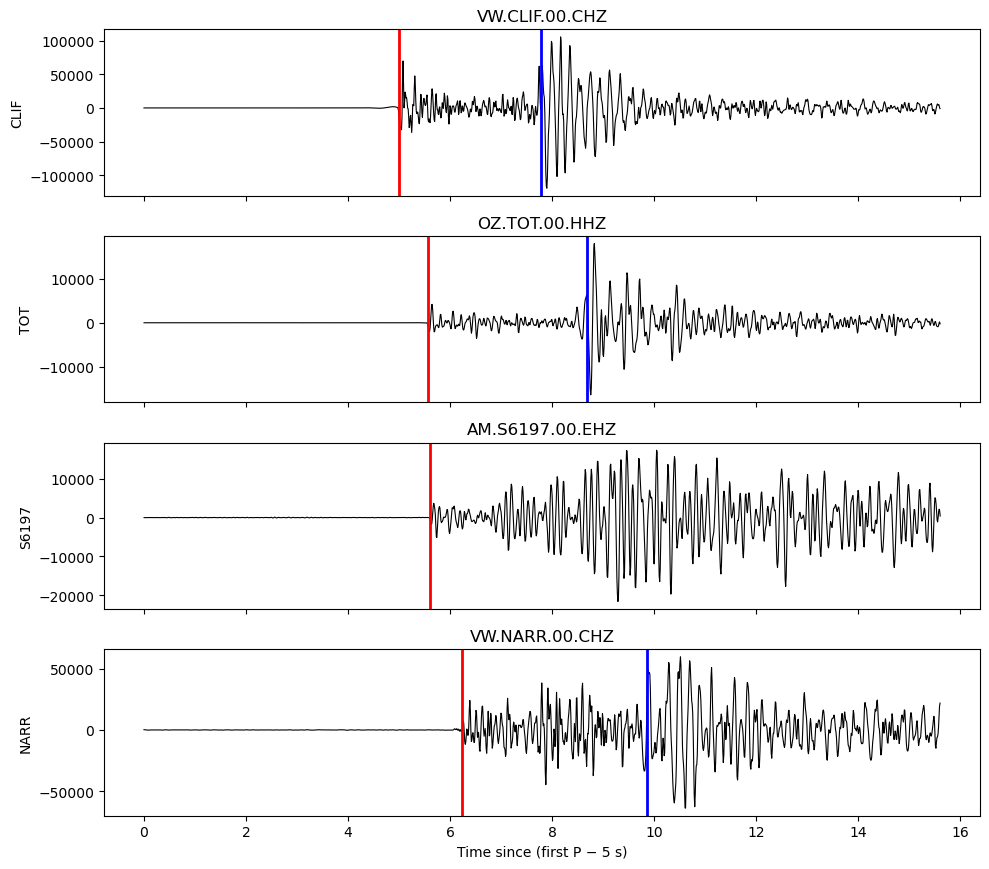

In [124]:
plot_station_picks_panel(st, stations_to_plot[:4], assignments=assignments, channel="*Z")

## Convert to Obspy Catalog and save

In [125]:
cat = convert_to_catalog(events, assignments)

In [126]:
cat.write("ex01/ex01_cat.xml", format="QUAKEML")